# Bag of visual words laboratory 

* Download the dataset [here](https://people.csail.mit.edu/torralba/code/spatialenvelope/spatial_envelope_256x256_static_8outdoorcategories.zip
)
* create a dataset directory
* extract the zip, rename the folder into "scenes" and put it into dataset folder

## Exploring the dataset

In [6]:
from glob import glob
filenames = glob('dataset/scenes/*.jpg')
print(filenames[:10])

['dataset/scenes/highway_urb720.jpg', 'dataset/scenes/coast_nat196.jpg', 'dataset/scenes/opencountry_land666.jpg', 'dataset/scenes/opencountry_natu65.jpg', 'dataset/scenes/highway_gre492.jpg', 'dataset/scenes/coast_n203030.jpg', 'dataset/scenes/tallbuilding_art1482.jpg', 'dataset/scenes/coast_art294.jpg', 'dataset/scenes/mountain_n199031.jpg', 'dataset/scenes/opencountry_natu51.jpg']


In [7]:
extract_classes = lambda x: x.split('/')[2].split('_')[0]

In [8]:
classes = list(map(extract_classes, filenames))
print(classes[:10])

['highway', 'coast', 'opencountry', 'opencountry', 'highway', 'coast', 'tallbuilding', 'coast', 'mountain', 'opencountry']


In [9]:
import pandas as pd 

In [10]:
df = pd.DataFrame({'filename': filenames, 'class': classes})
df.head()

,filename,class
0,dataset/scenes/highway_urb720.jpg,highway
1,dataset/scenes/coast_nat196.jpg,coast
2,dataset/scenes/opencountry_land666.jpg,opencountry
3,dataset/scenes/opencountry_natu65.jpg,opencountry
4,dataset/scenes/highway_gre492.jpg,highway


In [11]:
from sklearn.model_selection import train_test_split 
import numpy as np

In [12]:
np.random.seed(666)

In [13]:
df_train, df_test = train_test_split(df, test_size = .25)

In [14]:
df_train.head()

,filename,class
503,dataset/scenes/tallbuilding_a805043.jpg,tallbuilding
2114,dataset/scenes/opencountry_nat1121.jpg,opencountry
1119,dataset/scenes/forest_natu860.jpg,forest
452,dataset/scenes/coast_sun28.jpg,coast
19,dataset/scenes/opencountry_sclos18.jpg,opencountry


In [15]:
from matplotlib import pyplot as plt
from skimage import io 

## given an index from the dataframe, shows the image as a plot 

def showImage (dataframe, index):
    row = dataframe.iloc[index]
    im = io.imread(row['filename'])
    plt.title(f"Class: {row['class']}")
    plt.axis('off')
    plt.imshow(im)

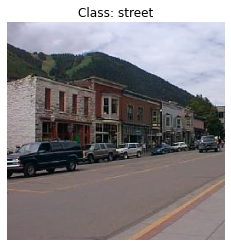

In [16]:
showImage(df_train, 24)

## Bag of visual words 

To keep it fast, we're gonna shrink the dataset into a subset of images. 

In [17]:
_, df_sm = train_test_split(df, test_size = .1)

In [18]:
np.random.seed(7)

In [19]:
print(len(df_sm))

269


In [20]:
df_sm_train, df_sm_test = train_test_split(df_sm, test_size = .15)

### Patch extraction

We need to install some libraries: 

> conda install -c menpo cyvlfeat

In [21]:
from cyvlfeat.sift import dsift  

In [22]:
im = io.imread(df_sm_train.iloc[0]['filename'], as_gray = True)
positions, descriptors = dsift(im)

In [29]:
print(positions.shape) ## position of the extracted images (center cell)
print(descriptors.shape) ## sift descriptor for each patch 

(61009, 2)
(61009, 128)


In [31]:
## let's change the sampling parameters
positions, descriptors = dsift(im, size = 5, step = 10)
print(positions.shape, descriptors.shape)

(625, 2) (625, 128)


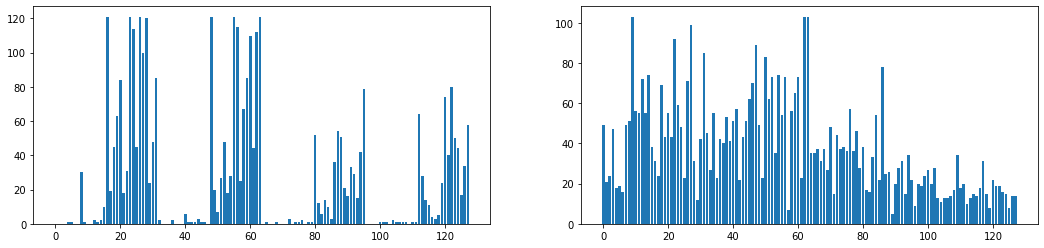

In [33]:
## Plot the descriptors of two images 

np.random.seed(400)
idx1, idx2 = np.random.choice(len(descriptors), 2)
d1 = descriptors[idx1]
d2 = descriptors[idx2]

plt.figure(figsize = (18, 4))
plt.subplot(121)
plt.bar(range(len(d1)), d1)
plt.subplot(122)
plt.bar(range(len(d2)), d2)
plt.show()


In [35]:
from tqdm import tqdm

def extract_and_describe (data, size = 5, step = 10):
    descriptors = []
    for i, row in tqdm(data.iterrows(), "Extracting/Describing patches", total = len(data)):
        im = io.imread(row['filename'], as_gray = True)
        _, desc = dsift(im, size = size, step = step)
        descriptors.append(desc)
    return np.vstack(descriptors)

In [36]:
train_descriptors = extract_and_describe(df_sm_train)
print(train_descriptors.shape)

Extracting/Describing patches: 100%|██████████| 228/228 [00:20<00:00, 11.18it/s]

(142500, 128)


### Creating the vocabulary

In [38]:
from sklearn.cluster import MiniBatchKMeans

In [41]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
kmeans = MiniBatchKMeans(500) ## 500 clusters 

In [44]:
kmeans.fit(train_descriptors)

MiniBatchKMeans(n_clusters=500)

In [46]:
kmeans.cluster_centers_.shape

(500, 128)

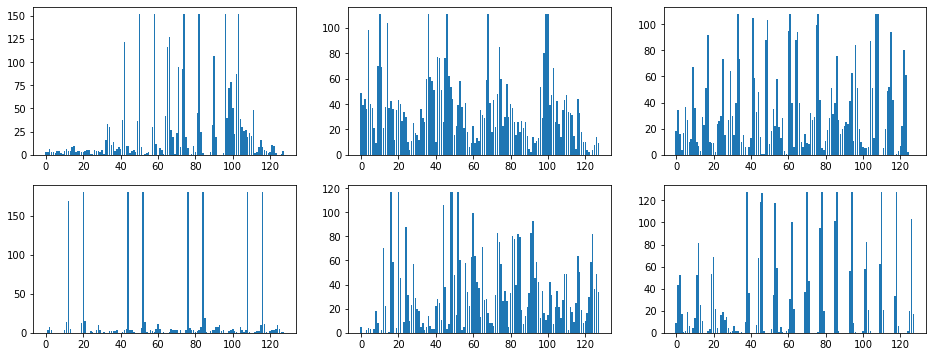

In [50]:
visual_words = np.random.permutation(kmeans.cluster_centers_)
plt.figure(figsize = (16, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.bar(range(len(visual_words[i])), visual_words[i])
plt.show()

### Representing image with the bag of visual words model


In [51]:
def load_and_describe (filename, size = 5, step = 10, kmeans = kmeans):
    im = io.imread(filename, as_gray = True)
    _, descriptors = dsift(im, size = size, step = step)
    tokens = kmeans.predict(descriptors)
    return tokens

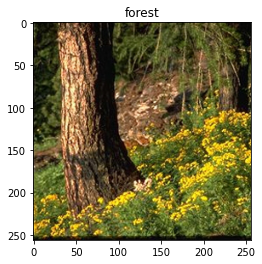

array([282, 309, 104, 309, 451, 308, 282, 322, 322,  83, 282,  71,  71,
       356,  83, 309, 308, 394, 394, 136, 136, 136, 307, 129, 282, 282,
       309, 104, 175, 394, 451, 282, 282, 394,  83, 309, 156, 156, 356,
        83, 356, 308,  83, 394, 451, 136, 136, 136, 307, 282], dtype=int32)

In [52]:
test_image = df_sm_test.iloc[0]
im_test = io.imread(test_image['filename'])

plt.imshow(im_test)
plt.title(test_image['class'])
plt.show()
tokens = load_and_describe(test_image['filename'])
#Let's show the first 50 tokens
tokens[:50]


In [54]:
# We can create a first representation by counting the number 
# of instances of each token. This can be done using the 
# histogram funciton of numpy .

bovw_representation, _ = np.histogram(tokens, bins = 500, range = (0, 499), normed = True)

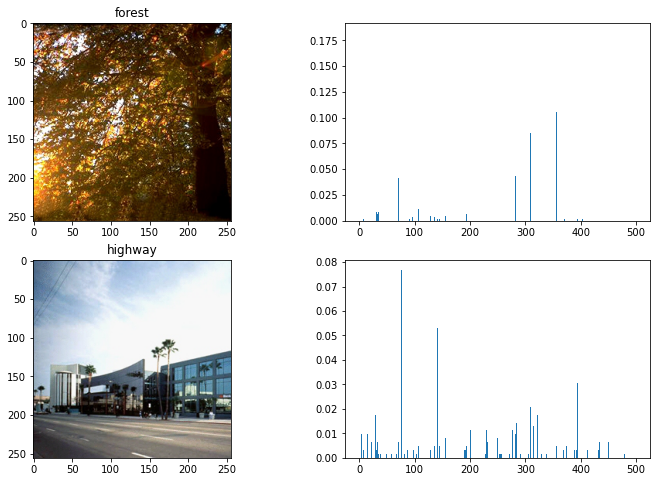

In [57]:
im0_path = df_sm_train.iloc[0]['filename']
im0_class = df_sm_train.iloc[0]['class']
im0 = io.imread(im0_path)
tokens0 = load_and_describe(im0_path)
bovw_representation0, _ = np.histogram(tokens0, bins=500, range=(0,499),normed=True)

im1_path = df_sm_train.iloc[1]['filename']
im1_class = df_sm_train.iloc[1]['class']
im1 = io.imread(im1_path)
tokens1 = load_and_describe(im1_path)
bovw_representation1, _ = np.histogram(tokens1, bins=500, range=(0,499),normed=True)

plt.figure(figsize=(12,8))
plt.subplot(221)
plt.imshow(im0)
plt.title(im0_class)
plt.subplot(222)
plt.bar(range(len(bovw_representation0)),bovw_representation0)
plt.subplot(223)
plt.imshow(im1)
plt.title(im1_class)
plt.subplot(224)
plt.bar(range(len(bovw_representation1)),bovw_representation1)
plt.show()


### Representing all training and test images


In [59]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(tokenizer = load_and_describe, vocabulary = range(500))
count_vect.fit(df_sm_train['filename'])

CountVectorizer(tokenizer=<function load_and_describe at 0x7fc0e717d790>,
                vocabulary=range(0, 500))

In [60]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf = TfidfTransformer(use_idf = False, norm = 'l1')
all_counts = count_vect.transform(df_sm_train['filename'])
tfidf.fit(all_counts)

TfidfTransformer(norm='l1', use_idf=False)

In [62]:
vwords_counts = count_vect.transform([im0_path])
bovw = tfidf.transform(vwords_counts)
bovw.sum()

1.0000000000000002

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(tokenizer = load_and_describe, vocabulary = range(500), use_idf = True)
tfidf.fit_transform(df_sm_train['filename'])

<228x500 sparse matrix of type '<class 'numpy.float64'>'
	with 23580 stored elements in Compressed Sparse Row format>

In [66]:
x_train = tfidf.transform(df_sm_train['filename'])
x_test = tfidf.transform(df_sm_test['filename'])
y_train = df_sm_train['class']
y_test = df_sm_test['class']
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(228, 500) (228,) (41, 500) (41,)


In [67]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_train_pred = lr.predict(x_train)
y_test_pred = lr.predict(x_test)

from sklearn.metrics import accuracy_score
print(f"Training accuracy: {accuracy_score(y_train, y_train_pred):0.2f}")
print(f"Testing accuracy: {accuracy_score(y_test, y_test_pred):0.2f}")

Training accuracy: 0.82
Testing accuracy: 0.66
